
=== Linear Regression with Robust SE (HC3) ===
                            OLS Regression Results                            
Dep. Variable:         gap_of_Account   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     41.25
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           1.46e-33
Time:                        18:50:37   Log-Likelihood:                 529.24
No. Observations:                 368   AIC:                            -1046.
Df Residuals:                     362   BIC:                            -1023.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

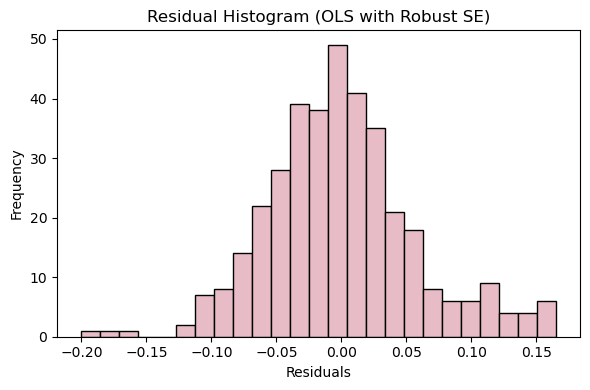

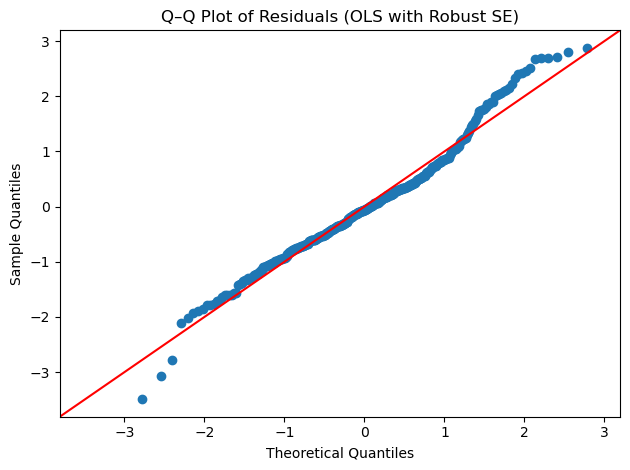

In [35]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ========= 1. Read data =========
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ========= 2. Define variables =========
y_col = "gap_of_Account"
x_vars = [
    "LFPR_Gap",
    "Women_Marriage_Rate",
    "Enroll_Female_Secondary",
    "logGDP",
    "WBL_Index"
]

# Robust column matching (case/space/underscore insensitive)
def find_col(cols, key):
    key_l = key.lower().replace("_", "").replace(" ", "")
    for c in cols:
        if key_l in c.lower().replace("_", "").replace(" ", ""):
            return c
    raise KeyError(f"Column not found: {key}")

y_col = find_col(df.columns, "gap_of_Account")
x_cols = [find_col(df.columns, x) for x in x_vars]

# ========= 3. Data cleaning & conversion =========
df_model = df[[y_col] + x_cols].copy()

def to_num(x):
    """Remove commas, %, and convert to float"""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"):
        s = s[:-1]
    try:
        return float(s)
    except:
        return np.nan

for c in [y_col] + x_cols:
    df_model[c] = df_model[c].apply(to_num)

# Drop rows with missing values
df_model = df_model.dropna()

# ========= 4. Run OLS with robust SE (HC3) =========
formula = f"{y_col} ~ {' + '.join(x_cols)}"
model = smf.ols(formula, data=df_model).fit(cov_type="HC3")

# ========= 5. Output regression summary =========
print("\n=== Linear Regression with Robust SE (HC3) ===")
print(model.summary())

# ========= 6. Create clean coefficient table =========
def star(p):
    """Add significance stars"""
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (robust SE, HC3) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4),
      "| AIC:", round(model.aic, 2),
      "| BIC:", round(model.bic, 2),
      "| N:", int(model.nobs))

# ========= 7. Residual diagnostics =========
residuals = model.resid

# --- Residual histogram ---
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (OLS with Robust SE)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Q–Q plot for normality check ---
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (OLS with Robust SE)")
plt.tight_layout()
plt.show()



=== Interaction Model (Mean-centered regressors, HC3 robust SE) ===
                            OLS Regression Results                            
Dep. Variable:         gap_of_Account   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     27.42
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           3.72e-33
Time:                        19:13:53   Log-Likelihood:                 540.77
No. Observations:                 368   AIC:                            -1064.
Df Residuals:                     359   BIC:                            -1028.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

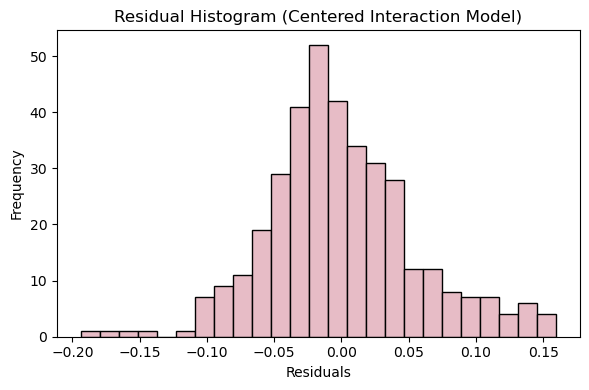

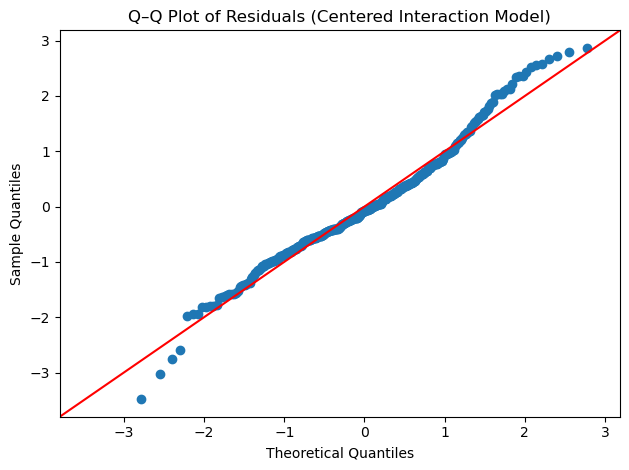

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============ 1) Read data ============
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ============ 2) Robust column finder ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

y_col   = find_col(df.columns, "gap_of_Account")
lfpr    = find_col(df.columns, "LFPR_Gap")
marry   = find_col(df.columns, "Women_Marriage_Rate")
edu     = find_col(df.columns, "Enroll_Female_Secondary")
loggdp  = find_col(df.columns, "logGDP")
wbl     = find_col(df.columns, "WBL_Index")

# ============ 3) Convert to numeric ============
def to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"): s = s[:-1]
    try: 
        return float(s)
    except:
        return np.nan

use_cols = [y_col, lfpr, marry, edu, loggdp, wbl]
dfm = df[use_cols].copy()
for c in use_cols:
    dfm[c] = dfm[c].apply(to_num)

# Drop rows with any missing among used variables
dfm = dfm.dropna().reset_index(drop=True)

# ============ 4) Mean-center continuous regressors ============
# Centering improves interpretability of main effects with interactions
for c in [lfpr, marry, edu, loggdp, wbl]:
    dfm[c + "_c"] = dfm[c] - dfm[c].mean()

# ============ 5) Build interactions on CENTERED variables ============
dfm["LFPRxWBL"] = dfm[lfpr + "_c"] * dfm[wbl + "_c"]
dfm["EDUxWBL"]  = dfm[edu  + "_c"] * dfm[wbl + "_c"]
dfm["LFPRxEDU"] = dfm[lfpr + "_c"] * dfm[edu + "_c"]

# ============ 6) Interaction OLS (centered) with HC3 robust SE ============
formula = f"""{y_col} ~ {lfpr}_c + {marry}_c + {edu}_c + {loggdp}_c + {wbl}_c
+ LFPRxWBL + EDUxWBL + LFPRxEDU
"""
model = smf.ols(formula, data=dfm).fit(cov_type="HC3")

print("\n=== Interaction Model (Mean-centered regressors, HC3 robust SE) ===")
print(model.summary())

# ============ 7) Tidy coef table with stars ============
def star(p): 
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (robust SE) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4), 
      "| AIC:", round(model.aic, 2), 
      "| BIC:", round(model.bic, 2), 
      "| N:", int(model.nobs))

# ============ 8) Residual diagnostics ============
resid = model.resid

plt.figure(figsize=(6,4))
plt.hist(resid, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (Centered Interaction Model)")
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Centered Interaction Model)")
plt.tight_layout(); plt.show()



=== Difference Model with Interactions (Mean-centered, HC3 robust SE) ===
                            OLS Regression Results                            
Dep. Variable:        GapDiff_CminusD   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.889
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           1.44e-05
Time:                        18:50:47   Log-Likelihood:                 318.86
No. Observations:                 227   AIC:                            -619.7
Df Residuals:                     218   BIC:                            -588.9
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

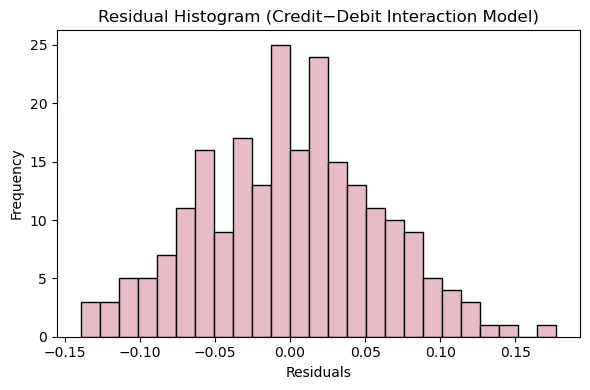

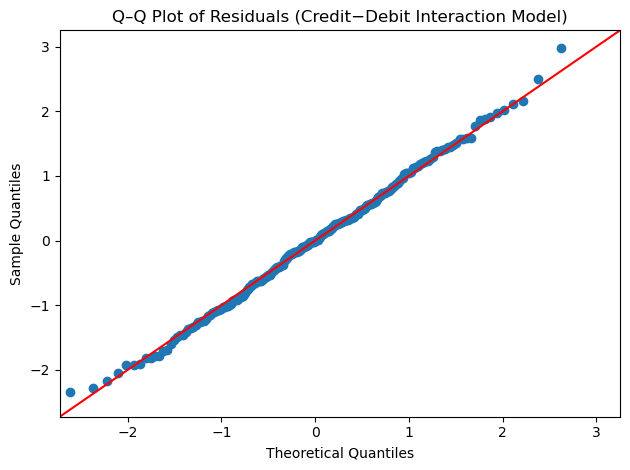

In [37]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============ 1) Read data ============
df = pd.read_csv("Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv")

# ============ 2) Column finder (case/space insensitive) ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

# ---- dependent variables ----
y_credit = find_col(df.columns, "gap_of_Credit")
y_debit  = find_col(df.columns, "gap_of_Debit")

# ---- independent variables ----
lfpr   = find_col(df.columns, "LFPR_Gap")
edu    = find_col(df.columns, "Enroll_Female_Secondary")
wbl    = find_col(df.columns, "WBL_Index")
loggdp = find_col(df.columns, "logGDP")
marry  = find_col(df.columns, "Women_Marriage_Rate")

# ============ 3) Convert to numeric ============
def to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"): s = s[:-1]
    try: return float(s)
    except: return np.nan

use_cols = [y_credit, y_debit, lfpr, edu, wbl, loggdp, marry]
dfm = df[use_cols].copy()
for c in use_cols:
    dfm[c] = dfm[c].apply(to_num)

dfm = dfm.dropna().reset_index(drop=True)

# ============ 4) Compute Credit−Debit difference ============
dfm["GapDiff_CminusD"] = dfm[y_credit] - dfm[y_debit]

# ============ 5) Mean-center all continuous variables ============
for c in [lfpr, edu, wbl, loggdp, marry]:
    dfm[c + "_c"] = dfm[c] - dfm[c].mean()

# ============ 6) Create interaction terms ============
dfm["LFPRxWBL"] = dfm[lfpr + "_c"] * dfm[wbl + "_c"]
dfm["EDUxWBL"]  = dfm[edu  + "_c"] * dfm[wbl + "_c"]
dfm["LFPRxEDU"] = dfm[lfpr + "_c"] * dfm[edu + "_c"]

# ============ 7) Regression model ============
formula = f"""
GapDiff_CminusD ~ {lfpr}_c + {edu}_c + {wbl}_c + {loggdp}_c + {marry}_c
+ LFPRxWBL + EDUxWBL + LFPRxEDU
"""
model = smf.ols(formula, data=dfm).fit(cov_type="HC3")

print("\n=== Difference Model with Interactions (Mean-centered, HC3 robust SE) ===")
print(model.summary())

# ============ 8) Tidy coefficients table ============
def star(p): 
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

coefs = pd.DataFrame({
    "Variable": model.params.index,
    "Coef": model.params.values,
    "Std.Err": model.bse.values,
    "t": model.tvalues.values,
    "P>|t|": model.pvalues.values
})
coefs["Sig"] = coefs["P>|t|"].apply(star)

print("\n=== Coefficients (Robust SE, HC3) ===")
print(coefs.round(6))

print("\nAdj. R²:", round(model.rsquared_adj, 4),
      "| AIC:", round(model.aic, 2),
      "| BIC:", round(model.bic, 2),
      "| N:", int(model.nobs))

# ============ 9) Residual diagnostics ============
resid = model.resid

plt.figure(figsize=(6,4))
plt.hist(resid, bins=25, color="#E7BCC6", edgecolor="black")
plt.title("Residual Histogram (Credit−Debit Interaction Model)")
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Credit−Debit Interaction Model)")
plt.tight_layout(); plt.show()


In [38]:
# 如果本地尚未安装 wbgapi，请先在命令行执行
# pip install wbgapi

import pandas as pd
import wbgapi as wb

# 读取你的数据
path = "Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv"  # 改成你的路径
df = pd.read_csv(path)

# 自动识别 ISO3 列
iso_candidates = ["iso", "iso3", "Economy_Code", "Economy_code", "country_code", "Country Code"]
iso_col = None
for c in df.columns:
    if c in iso_candidates:
        iso_col = c
        break
if iso_col is None:
    # 宽松匹配，包含 economy 和 code 的列名
    for c in df.columns:
        lc = c.lower()
        if "economy" in lc and "code" in lc:
            iso_col = c
            break
if iso_col is None:
    raise ValueError(f"未找到包含 ISO3 代码的列，请检查列名。当前列为：{list(df.columns)}")

# 规范成统一的 iso3 列
df["iso3"] = (
    df[iso_col].astype(str).str.upper().str.strip()
      .replace({"ROM": "ROU", "ZAR": "COD"})
)

# 从世界银行接口拉取经济体与地区信息
countries = pd.DataFrame(wb.economy.list())

def region_value(x):
    # 某些版本返回的是字典，需要取其中的 value
    if isinstance(x, dict):
        return x.get("value")
    return x

countries["region_name"] = countries["region"].apply(region_value)
wb_regions = countries[["id", "region_name"]].rename(columns={"id": "iso3"})
wb_regions["iso3"] = wb_regions["iso3"].str.upper().str.strip()

# 合并并过滤掉无地区或聚合项
df = df.merge(wb_regions, on="iso3", how="left")
df = df[~df["region_name"].isna() & (df["region_name"] != "Aggregates")].copy()

# 展示前几行用于检查
cols_to_show = ["iso3", "region_name"]
for c in ["iso", "country", "year"]:
    if c in df.columns and c not in cols_to_show:
        cols_to_show.append(c)
print(df[cols_to_show].head(12))



   iso3 region_name
0   AFG         MEA
1   AFG         MEA
2   AFG         MEA
3   ALB         ECS
4   ALB         ECS
5   ALB         ECS
6   ALB         ECS
7   ALB         ECS
8   DZA         MEA
9   DZA         MEA
10  DZA         MEA
11  DZA         MEA


In [41]:
import pandas as pd
import numpy as np
import wbgapi as wb
import statsmodels.formula.api as smf

# ============ 1) 读取数据 ============
path = "Account_LFPR_with_Marriage_Edu_logGDP_WBL.csv"
df = pd.read_csv(path)

# ============ 2) 利用 ISO3 与世界银行地区合并 得到 region_name ============
iso_candidates = ["iso", "iso3", "Economy_Code", "Economy_code", "country_code", "Country Code"]
iso_col = None
for c in df.columns:
    if c in iso_candidates:
        iso_col = c
        break
if iso_col is None:
    for c in df.columns:
        lc = c.lower()
        if "economy" in lc and "code" in lc:
            iso_col = c
            break
if iso_col is None:
    raise ValueError(f"未找到包含 ISO3 的列 当前列为：{list(df.columns)}")

df["iso3"] = (
    df[iso_col].astype(str).str.upper().str.strip()
      .replace({"ROM": "ROU", "ZAR": "COD"})
)

countries = pd.DataFrame(wb.economy.list())

def region_value(x):
    if isinstance(x, dict):
        return x.get("value")
    return x

countries["region_name"] = countries["region"].apply(region_value)
wb_regions = countries[["id", "region_name"]].rename(columns={"id": "iso3"})
wb_regions["iso3"] = wb_regions["iso3"].str.upper().str.strip()

df = df.merge(wb_regions, on="iso3", how="left")
df = df[~df["region_name"].isna() & (df["region_name"] != "Aggregates")].copy()

# ============ 3) 列名定位器 ============
def find_col(cols, key):
    key_l = key.lower().replace("_","").replace(" ","")
    for c in cols:
        if key_l in c.lower().replace("_","").replace(" ",""):
            return c
    raise KeyError(f"Column not found: {key}")

# 因变量
y_acc = find_col(df.columns, "gap_of_Account")
# 自变量
lfpr   = find_col(df.columns, "LFPR_Gap")
edu    = find_col(df.columns, "Enroll_Female_Secondary")
wbl    = find_col(df.columns, "WBL_Index")
loggdp = find_col(df.columns, "logGDP")
marry  = find_col(df.columns, "Women_Marriage_Rate")

# ============ 4) 数值清洗 ============
def to_num(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", "")
    if s.endswith("%"):
        s = s[:-1]
    try:
        return float(s)
    except:
        return np.nan

use_cols = [y_acc, lfpr, edu, wbl, loggdp, marry, "region_name"]
dfm = df[use_cols].copy()
for c in [y_acc, lfpr, edu, wbl, loggdp, marry]:
    dfm[c] = dfm[c].apply(to_num)

dfm = dfm.dropna(subset=[y_acc, lfpr, edu, wbl, loggdp, marry]).copy()
dfm = dfm[~dfm["region_name"].isna()].reset_index(drop=True)

# ============ 5) 去中心化 基于全样本均值 ============
for c in [lfpr, edu, wbl, loggdp, marry]:
    dfm[c + "_c"] = dfm[c] - dfm[c].mean()

# ============ 6) 交互项 ============
dfm["LFPRxWBL"] = dfm[lfpr + "_c"] * dfm[wbl + "_c"]
dfm["EDUxWBL"]  = dfm[edu  + "_c"] * dfm[wbl + "_c"]
dfm["LFPRxEDU"] = dfm[lfpr + "_c"] * dfm[edu + "_c"]

# ============ 7) 回归公式 ============
formula = f"""
{y_acc} ~ {lfpr}_c + {edu}_c + {wbl}_c + {loggdp}_c + {marry}_c
+ LFPRxWBL + EDUxWBL + LFPRxEDU
"""

# ============ 8) 打星函数 ============
def star(p):
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

# ============ 9) 逐地区回归 仅打印系数表与指标 不保存文件 不打印 OLS summary ============
regions = sorted(dfm["region_name"].dropna().unique().tolist())

for reg in regions:
    sub = dfm[dfm["region_name"] == reg].dropna(subset=[
        y_acc, lfpr + "_c", edu + "_c", wbl + "_c", loggdp + "_c", marry + "_c",
        "LFPRxWBL", "EDUxWBL", "LFPRxEDU"
    ]).copy()

    

    try:
        model = smf.ols(formula, data=sub).fit(cov_type="HC3")

        coefs = pd.DataFrame({
            "Variable": model.params.index,
            "Coef": model.params.values,
            "Std.Err": model.bse.values,
            "t": model.tvalues.values,
            "P>|t|": model.pvalues.values
        })
        coefs["Sig"] = coefs["P>|t|"].apply(star)

        # 打印系数表
        print("\n" + "="*90)
        print(f"Region: {reg}")
        print("=== Coefficients (Robust SE, HC3) ===")
        print(coefs.round(6))

        # 打印拟合指标
        print("\nAdj. R²:", round(model.rsquared_adj, 4),
              "| AIC:", round(model.aic, 2),
              "| BIC:", round(model.bic, 2),
              "| N:", int(model.nobs))

    except Exception as e:
        print("\n" + "="*90)
        print(f"Region: {reg}")
        print(f"[Skipped] Unable to estimate due to: {e}")



Region: EAS
=== Coefficients (Robust SE, HC3) ===
                    Variable      Coef   Std.Err         t     P>|t|  Sig
0                  Intercept -0.009042  0.020705 -0.436677  0.662345     
1                 LFPR_Gap_c -0.006757  0.002656 -2.544445  0.010945   **
2  Enroll_Female_Secondary_c -0.000823  0.001137 -0.723631  0.469292     
3                WBL_Index_c -0.004102  0.001572 -2.610156  0.009050  ***
4                   logGDP_c  0.000957  0.004386  0.218293  0.827201     
5      Women_Marriage_Rate_c -0.000389  0.000902 -0.431662  0.665987     
6                   LFPRxWBL  0.000059  0.000185  0.318811  0.749870     
7                    EDUxWBL -0.000051  0.000057 -0.894062  0.371289     
8                   LFPRxEDU -0.000234  0.000155 -1.516389  0.129421     

Adj. R²: 0.2794 | AIC: -114.17 | BIC: -100.44 | N: 34

Region: ECS
=== Coefficients (Robust SE, HC3) ===
                    Variable      Coef   Std.Err         t     P>|t|  Sig
0                  Intercept 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
